In [1]:
# MIT License

# Copyright (c) 2020 Daniel Bourke

# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:

# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.

In [2]:
# GitHub: https://github.com/mrdbourke/tensorflow-deep-learning

# Project 1: Food Vision: Transfer Learning and Fine Tuning

# Get workspace ready

In [3]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-fbc169e9-94c5-2562-dddc-f6c84703cac6)


In [4]:
import tensorflow as tf
print(tf.__version__)

2.18.0


In [91]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1.Data pre-processing

## Import and explore datasets

In [6]:
import tensorflow_datasets as tfds

In [7]:
datasets_list = tfds.list_builders()
print("food101" in datasets_list)

True


In [8]:
ls

sample_data/


In [9]:
(train_data, test_data), ds_info = tfds.load(name="food101", split=["train", "validation"], shuffle_files=False, as_supervised=True, with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/incomplete.3GW12D_2.0.0/food101-train.tfrecord*...:   0%|         …

Generating validation examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/incomplete.3GW12D_2.0.0/food101-validation.tfrecord*...:   0%|    …

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


In [10]:
test_data_tmp = test_data

In [11]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [12]:
class_names = ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [13]:
train_one_sample = train_data.take(1)

In [14]:
train_one_sample

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [15]:
for image, label in train_one_sample:
  print(f"""
  Image shape: {image.shape}
  Image dtype: {image.dtype}
  Target class from Food101 (tensor form): {label}
  Class name (str form): {class_names[label.numpy()]}
        """)


  Image shape: (512, 512, 3)
  Image dtype: <dtype: 'uint8'>
  Target class from Food101 (tensor form): 56
  Class name (str form): huevos_rancheros
        


In [16]:
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

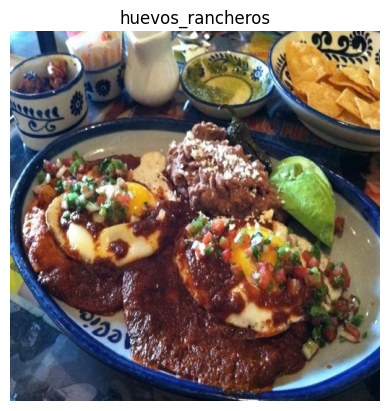

In [17]:
import matplotlib.pyplot as plt
plt.imshow(image)
plt.title(class_names[label.numpy()])
plt.axis(False);

## Create preprocessing functions

In [18]:
def preprocess_img(image, label, img_shape=224):

  image = tf.image.resize(image, [img_shape, img_shape])
  image = image/255.
  return tf.cast(image, tf.float32), label

In [19]:
preprocessed_img = preprocess_img(image, label)[0]
print(f"Image before preprocessing:\n {image[:2]}...,\nShape: {image.shape},\nDatatype: {image.dtype}\n")
print(f"Image after preprocessing:\n {preprocessed_img[:2]}...,\nShape: {preprocessed_img.shape},\nDatatype: {preprocessed_img.dtype}")

Image before preprocessing:
 [[[233 253 251]
  [231 253 250]
  [228 254 251]
  ...
  [ 85  82  89]
  [ 68  67  75]
  [ 57  57  67]]

 [[232 254 252]
  [229 254 251]
  [226 255 251]
  ...
  [121 116 120]
  [100  99 104]
  [ 86  85  91]]]...,
Shape: (512, 512, 3),
Datatype: <dtype: 'uint8'>

Image after preprocessing:
 [[[0.9045418  0.99467784 0.9843137 ]
  [0.87450975 0.9998999  0.9889956 ]
  [0.81202483 1.         0.9818327 ]
  ...
  [0.5516191  0.5079419  0.47538933]
  [0.4750693  0.4520202  0.45864302]
  [0.32922992 0.32580858 0.35151908]]

 [[0.8685274  0.997559   0.9934574 ]
  [0.84121644 1.         0.9957783 ]
  [0.77809125 0.99837935 0.98811525]
  ...
  [0.81828696 0.76792717 0.6800323 ]
  [0.7726689  0.745518   0.68561417]
  [0.6883936  0.6730074  0.63221115]]]...,
Shape: (224, 224, 3),
Datatype: <dtype: 'float32'>


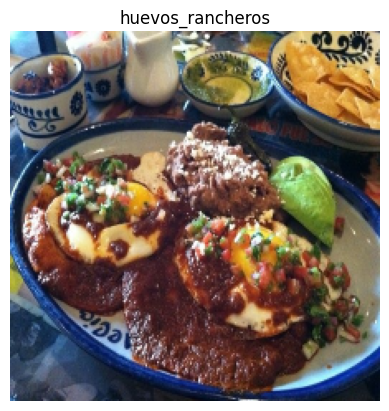

In [20]:
plt.imshow(preprocessed_img)
plt.title(class_names[label])
plt.axis(False);

## Batch and prepare datasets

In [21]:
train_data, test_data

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>)

In [22]:
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
test_data = test_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)

In [23]:
train_data, test_data

(<_ParallelMapDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>,
 <_ParallelMapDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>)

In [24]:
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)
test_data = test_data.batch(32).prefetch(tf.data.AUTOTUNE)

In [25]:
train_data, test_data

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

In [26]:
from tensorflow.keras import layers

rescale = layers.Rescaling(1)
test_data1 = test_data.map(lambda x, y: (rescale(x), y))

In [27]:
train_data, test_data, test_data1

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_MapDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

In [28]:
len(train_data), len(test_data)

(2368, 790)

## Create modelling callbacks

In [29]:
checkpoint_path = "model_checkpoints/cp.weights.h5"

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_accuracy",
                                                      save_best_only=True,
                                                      save_weights_only=True,
                                                      verbose=0)

## Setup mixed precision training

In [30]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy(policy="mixed_float16")

In [31]:
mixed_precision.global_policy()

<DTypePolicy "mixed_float16">

# 2.Building a model

In [32]:
from tensorflow.keras import layers

input_shape = (224, 224, 3)
base_model = tf.keras.applications.MobileNetV2(include_top=False, weights='imagenet')
base_model.trainable = False

inputs = layers.Input(shape=input_shape, name="input_layer")
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
x = layers.Dense(len(class_names))(x)
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)
model = tf.keras.Model(inputs, outputs)

model.compile(loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(), metrics=["accuracy"])

<ipython-input-32-87e0bb0871f8>:4: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(include_top=False, weights='imagenet')


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [33]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pooling_layer                   │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 101)            │       129,381 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast_1 (Cast)                   │ (None, 101)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ softmax_float32 (Activation)    │ (None, 101)            │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,387,365 (9.11 MB)

 Trainable params: 129,381 (505.39 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [34]:
for layer in model.layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <DTypePolicy "mixed_float16">
mobilenetv2_1.00_224 False float32 <DTypePolicy "mixed_float16">
pooling_layer True float32 <DTypePolicy "mixed_float16">
dense True float32 <DTypePolicy "mixed_float16">
softmax_float32 True float32 <DTypePolicy "float32">


In [35]:
for layer in model.layers[1].layers[:20]:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer False float32 <DTypePolicy "mixed_float16">
Conv1 False float32 <DTypePolicy "mixed_float16">
bn_Conv1 False float32 <DTypePolicy "mixed_float16">
Conv1_relu False float32 <DTypePolicy "mixed_float16">
expanded_conv_depthwise False float32 <DTypePolicy "mixed_float16">
expanded_conv_depthwise_BN False float32 <DTypePolicy "mixed_float16">
expanded_conv_depthwise_relu False float32 <DTypePolicy "mixed_float16">
expanded_conv_project False float32 <DTypePolicy "mixed_float16">
expanded_conv_project_BN False float32 <DTypePolicy "mixed_float16">
block_1_expand False float32 <DTypePolicy "mixed_float16">
block_1_expand_BN False float32 <DTypePolicy "mixed_float16">
block_1_expand_relu False float32 <DTypePolicy "mixed_float16">
block_1_pad False float32 <DTypePolicy "mixed_float16">
block_1_depthwise False float32 <DTypePolicy "mixed_float16">
block_1_depthwise_BN False float32 <DTypePolicy "mixed_float16">
block_1_depthwise_relu False float32 <DTypePolicy "mixed_float16">
bloc

## Build a feature extraction model using transfer learning

In [36]:
tf.get_logger().setLevel('ERROR')

history_101_food_classes_feature_extract = model.fit(train_data,
                                                     epochs=1,                # 5
                                                     steps_per_epoch=len(train_data),
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)))

2368/2368 ━━━━━━━━━━━━━━━━━━━━ 169s 66ms/step - accuracy: 0.3811 - loss: 2.6159 - val_accuracy: 0.5797 - val_loss: 1.6089


In [37]:
results_feature_extract_model = model.evaluate(test_data)
results_feature_extract_model

790/790 ━━━━━━━━━━━━━━━━━━━━ 46s 59ms/step - accuracy: 0.5741 - loss: 1.6359


[1.6428669691085815, 0.5710495114326477]

In [38]:
def load_and_prep_image(filename, img_shape=224, scale=True):

  img = tf.io.read_file(filename)
  img = tf.image.decode_jpeg(img)
  img = tf.image.resize(img, [img_shape, img_shape])
  if scale:
    return img/255.
  else:
    return img

In [39]:
def pred_and_plot(model, filename, class_names):

  img = load_and_prep_image(filename)
  pred = model.predict(tf.expand_dims(img, axis=0))
  if len(pred[0]) > 1:
    pred_class = class_names[pred.argmax()]
  else:
    pred_class = class_names[int(tf.round(pred)[0][0])]
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False)

In [40]:
!wget -q https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-pizza-dad.jpeg           ###############
!wget -q https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-steak.jpeg
!wget -q https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-hamburger.jpeg
!wget -q https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-sushi.jpeg

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


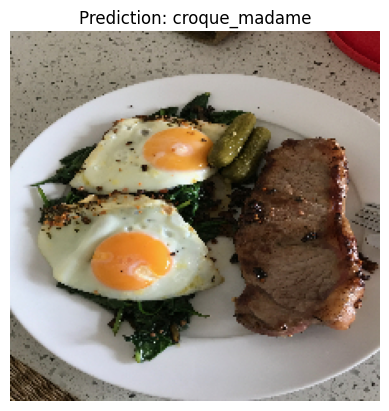

In [41]:
pred_and_plot(model, "03-steak.jpeg", class_names)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


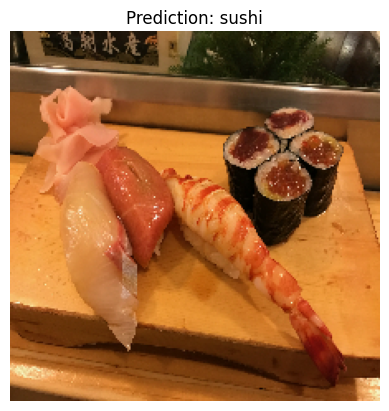

In [42]:
pred_and_plot(model, "03-sushi.jpeg", class_names)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


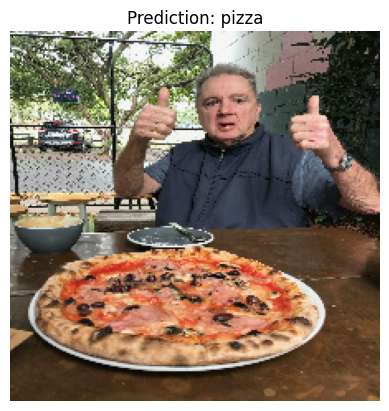

In [43]:
pred_and_plot(model, "03-pizza-dad.jpeg", class_names)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


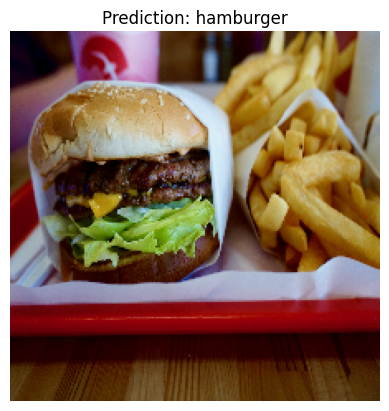

In [44]:
pred_and_plot(model, "03-hamburger.jpeg", class_names)

In [45]:
save_dir = "07_MobileNetV2_feature_extract_model_mixed_precision.keras"
model.save(save_dir)

In [46]:
loaded_saved_model = tf.keras.models.load_model(save_dir)

In [47]:
for layer in loaded_saved_model.layers[1].layers[:20]:
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <DTypePolicy "mixed_float16">
Conv1 False float32 <DTypePolicy "mixed_float16">
bn_Conv1 False float32 <DTypePolicy "mixed_float16">
Conv1_relu False float32 <DTypePolicy "mixed_float16">
expanded_conv_depthwise False float32 <DTypePolicy "mixed_float16">
expanded_conv_depthwise_BN False float32 <DTypePolicy "mixed_float16">
expanded_conv_depthwise_relu False float32 <DTypePolicy "mixed_float16">
expanded_conv_project False float32 <DTypePolicy "mixed_float16">
expanded_conv_project_BN False float32 <DTypePolicy "mixed_float16">
block_1_expand False float32 <DTypePolicy "mixed_float16">
block_1_expand_BN False float32 <DTypePolicy "mixed_float16">
block_1_expand_relu False float32 <DTypePolicy "mixed_float16">
block_1_pad False float32 <DTypePolicy "mixed_float16">
block_1_depthwise False float32 <DTypePolicy "mixed_float16">
block_1_depthwise_BN False float32 <DTypePolicy "mixed_float16">
block_1_depthwise_relu False float32 <DTypePolicy "mixed_float16">
block

In [48]:
results_loaded_saved_model = loaded_saved_model.evaluate(test_data)
results_loaded_saved_model

790/790 ━━━━━━━━━━━━━━━━━━━━ 54s 62ms/step - accuracy: 0.5741 - loss: 1.6359


[1.6428669691085815, 0.5710495114326477]

In [49]:
assert np.isclose(results_feature_extract_model, results_loaded_saved_model).all()

## Fine-tune the feature extraction model

In [50]:
loaded_gs_model = tf.keras.models.load_model("07_MobileNetV2_feature_extract_model_mixed_precision.keras")

In [51]:
loaded_gs_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pooling_layer                   │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 101)            │       129,381 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast_5 (Cast)                   │ (None, 101)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ softmax_float32 (Activation)    │ (None, 101)            │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,646,133 (10.09 MB)

 Trainable params: 129,381 (505.39 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

 Optimizer params: 258,768 (1010.82 KB)

In [52]:
results_loaded_gs_model = loaded_gs_model.evaluate(test_data)
results_loaded_gs_model

790/790 ━━━━━━━━━━━━━━━━━━━━ 50s 57ms/step - accuracy: 0.5741 - loss: 1.6359


[1.6428669691085815, 0.5710495114326477]

In [53]:
for layer in loaded_gs_model.layers:
    layer.trainable = True
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <DTypePolicy "mixed_float16">
mobilenetv2_1.00_224 True float32 <DTypePolicy "mixed_float16">
pooling_layer True float32 <DTypePolicy "mixed_float16">
dense True float32 <DTypePolicy "mixed_float16">
softmax_float32 True float32 <DTypePolicy "float32">


In [54]:
for layer in loaded_gs_model.layers[1].layers[:20]:
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <DTypePolicy "mixed_float16">
Conv1 True float32 <DTypePolicy "mixed_float16">
bn_Conv1 True float32 <DTypePolicy "mixed_float16">
Conv1_relu True float32 <DTypePolicy "mixed_float16">
expanded_conv_depthwise True float32 <DTypePolicy "mixed_float16">
expanded_conv_depthwise_BN True float32 <DTypePolicy "mixed_float16">
expanded_conv_depthwise_relu True float32 <DTypePolicy "mixed_float16">
expanded_conv_project True float32 <DTypePolicy "mixed_float16">
expanded_conv_project_BN True float32 <DTypePolicy "mixed_float16">
block_1_expand True float32 <DTypePolicy "mixed_float16">
block_1_expand_BN True float32 <DTypePolicy "mixed_float16">
block_1_expand_relu True float32 <DTypePolicy "mixed_float16">
block_1_pad True float32 <DTypePolicy "mixed_float16">
block_1_depthwise True float32 <DTypePolicy "mixed_float16">
block_1_depthwise_BN True float32 <DTypePolicy "mixed_float16">
block_1_depthwise_relu True float32 <DTypePolicy "mixed_float16">
block_1_project True

In [55]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3)
checkpoint_path = "fine_tune_checkpoints/cp.weights.h5"

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, save_best_only=True, monitor="val_loss")

In [56]:
loaded_gs_model.compile(loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(0.0001), metrics=["accuracy"])

# 3.Training a model

## Train the model using trained dataset

In [57]:
history_101_food_classes_all_data_fine_tune = loaded_gs_model.fit(train_data,
                                                        epochs=1,                         # 5
                                                        steps_per_epoch=len(train_data),
                                                        validation_data=test_data,
                                                        validation_steps=int(0.15 * len(test_data)))

2368/2368 ━━━━━━━━━━━━━━━━━━━━ 268s 86ms/step - accuracy: 0.5665 - loss: 1.7094 - val_accuracy: 0.6700 - val_loss: 1.2391


In [58]:
results_fine_tuning_model = loaded_gs_model.evaluate(test_data)
results_fine_tuning_model

790/790 ━━━━━━━━━━━━━━━━━━━━ 51s 65ms/step - accuracy: 0.6636 - loss: 1.2624


[1.266690969467163, 0.6622970104217529]

In [59]:
save_dir2 = "07_MobileNetV2_fine_tuned_101_classes_mixed_precision.keras"
loaded_gs_model.save(save_dir2)

In [60]:
loaded_gs_model.save("07_MobileNetV2_fine_tuned_101_classes_mixed_precision.keras")

In [61]:
loaded_fine_tuned_gs_model = tf.keras.models.load_model("07_MobileNetV2_fine_tuned_101_classes_mixed_precision.keras")

In [62]:
results_downloaded_fine_tuned_gs_model = loaded_fine_tuned_gs_model.evaluate(test_data)
results_downloaded_fine_tuned_gs_model

790/790 ━━━━━━━━━━━━━━━━━━━━ 51s 58ms/step - accuracy: 0.6636 - loss: 1.2624


[1.266690969467163, 0.6622970104217529]

In [63]:
assert np.isclose(results_fine_tuning_model, results_downloaded_fine_tuned_gs_model).all()

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


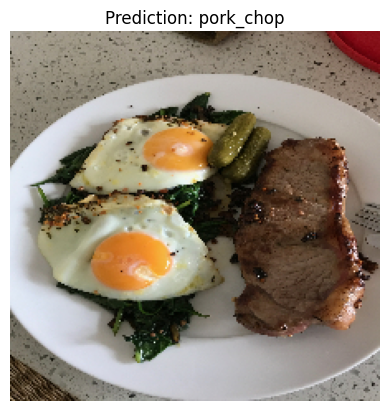

In [64]:
pred_and_plot(loaded_gs_model, "03-steak.jpeg", class_names)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


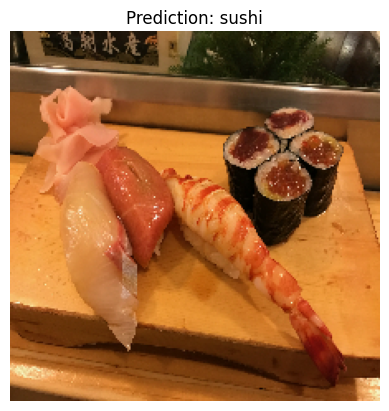

In [65]:
pred_and_plot(loaded_gs_model, "03-sushi.jpeg", class_names)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


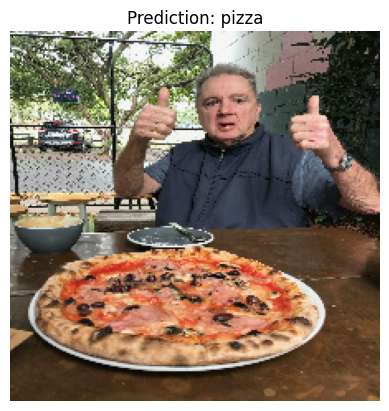

In [66]:
pred_and_plot(loaded_gs_model, "03-pizza-dad.jpeg", class_names)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


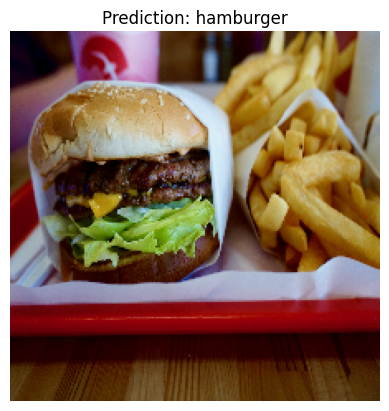

In [67]:
pred_and_plot(loaded_gs_model, "03-hamburger.jpeg", class_names)

# 4.Model evaluation

In [68]:
save_dir3 = "07_MobileNetV2_fine_tuned_101_classes_mixed_precision.keras"
loaded_fine_tuned_gs_model3 = tf.keras.models.load_model(save_dir3)

In [69]:
loaded_fine_tuned_gs_model3 = tf.keras.models.load_model("07_MobileNetV2_fine_tuned_101_classes_mixed_precision.keras")

## Make predictions on food images using validation dataset

In [70]:
pred_probs = loaded_fine_tuned_gs_model3.predict(test_data, verbose=1)
pred_probs

790/790 ━━━━━━━━━━━━━━━━━━━━ 51s 61ms/step


array([[2.1681913e-04, 3.6365071e-07, 9.7317979e-07, ..., 1.7659097e-05,
        3.3844990e-04, 1.1034159e-02],
       [5.7404685e-07, 8.1883380e-09, 1.7407756e-06, ..., 8.0154898e-08,
        2.3061530e-06, 8.1417163e-08],
       [2.0878417e-04, 1.0979045e-05, 2.4081483e-03, ..., 1.4514325e-06,
        7.6209675e-05, 1.9886419e-03],
       ...,
       [8.3423378e-03, 2.1334994e-05, 6.1734849e-05, ..., 3.7658501e-06,
        1.7277604e-05, 1.8760263e-03],
       [2.2530426e-04, 8.3009667e-08, 2.9553488e-05, ..., 3.3418157e-06,
        1.4291134e-05, 3.2458160e-05],
       [9.0802344e-04, 1.1655771e-05, 2.2339166e-04, ..., 1.5029372e-03,
        9.2398805e-05, 1.4423250e-04]], dtype=float32)

In [71]:
pred_probs.shape

(25250, 101)

In [72]:
sum(pred_probs[0])

np.float32(0.9999999)

In [73]:
print(f"Number of prediction probabilities for sample 0: {len(pred_probs[0])}")
print(f"What prediction probability sample 0 looks like:\n {pred_probs[0]}")
print(f"The class with the highest predicted probability by the model for sample 0: {pred_probs[0].argmax()}")

Number of prediction probabilities for sample 0: 101
What prediction probability sample 0 looks like:
 [2.16819128e-04 3.63650713e-07 9.73179795e-07 1.17882526e-04
 2.21960858e-04 5.40841371e-04 4.34318856e-08 5.07006407e-05
 9.25546791e-03 1.98129578e-06 2.04849093e-05 6.76538248e-09
 5.74513469e-05 5.07157762e-03 1.19057135e-03 7.30411921e-06
 1.45608941e-02 3.13014956e-04 1.72760082e-08 1.61369030e-07
 4.89345496e-07 2.03682721e-04 1.95526751e-03 1.72863278e-04
 1.23986308e-06 6.51989822e-08 2.49033183e-05 3.83513980e-04
 3.02111516e-06 8.56246471e-01 2.61062454e-03 1.50186243e-04
 3.80529440e-04 8.12636763e-11 5.40841371e-04 1.97713462e-07
 1.46399043e-05 4.03371814e-06 1.57299862e-08 2.50459243e-06
 9.65606318e-07 6.51989822e-08 8.14833402e-06 4.94221422e-06
 3.07978176e-08 1.62097369e-03 1.31152922e-09 2.19771027e-05
 1.13128426e-05 2.46058363e-07 2.42243601e-07 1.30406175e-08
 1.46091588e-06 4.64278082e-06 1.66491418e-07 1.52230941e-05
 4.01075085e-05 1.02203003e-05 9.11197532e-

In [74]:
pred_classes = pred_probs.argmax(axis=1)
pred_classes[:10]

array([ 29,  81,  47,  53,  97,  97,  10,  31,   3, 100])

In [75]:
test_one_sample = test_data_tmp.take(1)

In [76]:
test_one_sample

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [77]:
for image1, label1 in test_one_sample:
  print(f"""
  Image shape: {image1.shape}
  Image dtype: {image1.dtype}
  Target class from Food101 (tensor form): {label1}
  # Class name (str form): {class_names[label1.numpy()]}
        """)


  Image shape: (382, 512, 3)
  Image dtype: <dtype: 'uint8'>
  Target class from Food101 (tensor form): 29
  # Class name (str form): cup_cakes
        


In [78]:
def one_hot_encode_labels(image, label):

  num_classes = len(class_names)
  one_hot_label = tf.one_hot(label, depth=num_classes, dtype=tf.int64)
  return image, one_hot_label
test_data1 = test_data1.map(one_hot_encode_labels)

In [79]:
y_labels = []
for images, labels in test_data1.unbatch():
  y_labels.append(labels.numpy().argmax())

y_labels[:10]

[np.int64(29),
 np.int64(81),
 np.int64(91),
 np.int64(53),
 np.int64(97),
 np.int64(97),
 np.int64(10),
 np.int64(31),
 np.int64(3),
 np.int64(100)]

In [80]:
len(y_labels), pred_classes.shape

(25250, (25250,))

## Evaluate for precision, recall, and f1 scores

In [81]:
from sklearn.metrics import accuracy_score

sklearn_accuracy = accuracy_score(y_true=y_labels, y_pred=pred_classes)
sklearn_accuracy

0.6622970297029703

In [82]:
from sklearn.metrics import classification_report

print(classification_report(y_labels, pred_classes))

              precision    recall  f1-score   support

           0       0.42      0.30      0.35       250
           1       0.95      0.41      0.58       250
           2       0.60      0.85      0.70       250
           3       0.62      0.82      0.70       250
           4       0.61      0.69      0.65       250
           5       0.51      0.62      0.56       250
           6       0.46      0.92      0.62       250
           7       0.83      0.80      0.81       250
           8       0.27      0.70      0.39       250
           9       0.90      0.32      0.47       250
          10       0.58      0.61      0.59       250
          11       0.62      0.82      0.71       250
          12       0.72      0.74      0.73       250
          13       0.83      0.55      0.66       250
          14       0.65      0.68      0.67       250
          15       0.46      0.44      0.45       250
          16       0.38      0.75      0.51       250
          17       0.64    

## Create a confusion matrix, and find the most wrong predictions

In [83]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False):

  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
  n_classes = cm.shape[0]
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues)
  fig.colorbar(cax)

  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])

  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes),
         yticks=np.arange(n_classes),
         xticklabels=labels,
         yticklabels=labels)

  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)
  threshold = (cm.max() + cm.min()) / 2.

  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  if savefig:
    fig.savefig("confusion_matrix.png")

In [84]:
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=class_names,
                      figsize=(100, 100),
                      text_size=20,
                      norm=False,
                      savefig=True)

In [85]:
pred_df = pd.DataFrame({"y_true": y_labels,
                        "y_pred": pred_classes,
                        "pred_conf": pred_probs.max(axis=1),
                        "y_true_classname": [class_names[i] for i in y_labels],
                        "y_pred_classname": [class_names[i] for i in pred_classes]})
pred_df.head()

y_true  y_pred  pred_conf     y_true_classname y_pred_classname
0      29      29   0.856246            cup_cakes        cup_cakes
1      81      81   0.990816                ramen            ramen
2      91      47   0.787527  spaghetti_carbonara          gnocchi
3      53      53   0.560550            hamburger        hamburger
4      97      97   0.413054             takoyaki         takoyaki

In [86]:
pred_df["pred_correct"] = pred_df["y_true"] == pred_df["y_pred"]
pred_df.head()

y_true  y_pred  pred_conf     y_true_classname y_pred_classname  \
0      29      29   0.856246            cup_cakes        cup_cakes   
1      81      81   0.990816                ramen            ramen   
2      91      47   0.787527  spaghetti_carbonara          gnocchi   
3      53      53   0.560550            hamburger        hamburger   
4      97      97   0.413054             takoyaki         takoyaki   

   pred_correct  
0          True  
1          True  
2         False  
3          True  
4          True

In [87]:
top_100_wrong = pred_df[pred_df["pred_correct"] == False].sort_values("pred_conf", ascending=False)[:100]
top_100_wrong.head(20)

y_true  y_pred  pred_conf         y_true_classname y_pred_classname  \
21257      30      29   0.999295             deviled_eggs        cup_cakes   
900        14      29   0.998379              carrot_cake        cup_cakes   
3148       82      47   0.997805                  ravioli          gnocchi   
16129      65      69   0.997625                  mussels          oysters   
24038       2       6   0.996194                  baklava         beignets   
25235      42       6   0.995636             french_toast         beignets   
6618       58      45   0.995441                ice_cream    frozen_yogurt   
9991       30      29   0.995151             deviled_eggs        cup_cakes   
8955       85       2   0.994578                   samosa          baklava   
7659       68      70   0.994523              onion_rings         pad_thai   
12578      93      79   0.994126                    steak        prime_rib   
13884      46      10   0.994086             garlic_bread       bruschetta   
21452      49       6   0.993893  grilled_cheese_sandwich         beignets   
1812       31      29   0.993795                   donuts        cup_cakes   
2934       22      29   0.992792         chocolate_mousse        cup_cakes   
3566       53      25   0.992303                hamburger    club_sandwich   
24815      49      52   0.991559  grilled_cheese_sandwich            gyoza   
23251      14       2   0.991503              carrot_cake          baklava   
12614      58      45   0.991098                ice_cream    frozen_yogurt   
22441      16      17   0.991039               cheesecake     cheese_plate   

       pred_correct  
21257         False  
900           False  
3148          False  
16129         False  
24038         False  
25235         False  
6618          False  
9991          False  
8955          False  
7659          False  
12578         False  
13884         False  
21452         False  
1812          False  
2934          False  
3566          False  
24815         False  
23251         False  
12614         False  
22441         False

# 5.Deployment

## Make predictions on custom food images with prediction probabilities

In [94]:
custom_food_images1 = ["custom_food_images/" + img_path for img_path in os.listdir("custom_food_images")]
custom_food_images1

['custom_food_images/h1.jpeg',
 'custom_food_images/p1.jpeg',
 'custom_food_images/sh1.jpeg']

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


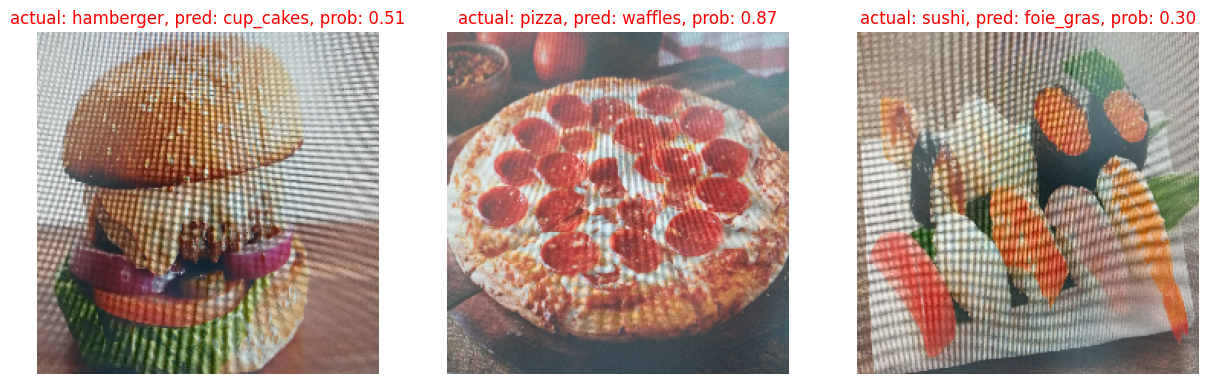

In [96]:
from matplotlib import pyplot as plt

i = 1
fig = plt.figure(figsize=(15, 7))

for img in custom_food_images1:
  img = load_and_prep_image(img, scale=True)
  if i == 1:
    class_name = 'hamberger'
  elif i == 2:
    class_name = 'pizza'
  else:
    class_name = 'sushi'

  pred_prob = loaded_fine_tuned_gs_model3.predict(tf.expand_dims(img, axis=0))
  pred_class = class_names[pred_prob.argmax()]
  plt.subplot(1, 3, i)
  plt.imshow(img)

  if class_name == pred_class:
    title_color = "g"
  else:
    title_color = "r"

  plt.title(f"actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c=title_color)
  plt.axis(False)
  i = i +1